In [1]:
import spacy
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout, Flatten, Embedding, TextVectorization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
import scikitplot as skplt
import numpy as np
from tqdm.notebook import tqdm_notebook


# Read in preprocessed data

In [2]:
train_x = pd.read_csv('./x_train.csv')
train_y = pd.read_csv('./y_train.csv')
test_x = pd.read_csv('./x_test.csv')
test_y = pd.read_csv('./y_test.csv')

train_df = pd.concat([train_x, train_y], axis=1)
test_df = pd.concat([test_x, test_y], axis=1)

train_df = train_df[['text', 'label']]
test_df = test_df[['text', 'label']]

In [3]:
train_df

,text,label
0,bromwell high cartoon comedy ran time program ...,+
1,homelessness houselessness george carlin state...,+
2,brilliant overacting lesley ann warren best dr...,+
3,easily underrated film inn brook cannon sure f...,+
4,typical mel brook film much le slapstick movie...,+
...,...,...
24995,towards end movie felt technical felt like cla...,-
24996,kind movie enemy content watch time bloody tru...,-
24997,saw descent last night stockholm film festival...,-
24998,film pick pound turn rather good 23rd century ...,-


In [4]:
train_df = train_df.sample(len(train_df), random_state=42, ignore_index=True)
train_df

,text,label
0,panic street richard widmark play u navy docto...,+
1,ask first one really better one look sarah g r...,-
2,big fan faerie tale theatre ive seen one best ...,+
3,finished reading book dillinger movie horribly...,-
4,greg davis bryan daly take crazed statement te...,-
...,...,...
24995,roommate nearly shorted tv numerous spittakes ...,-
24996,michelle rodriguez defining actress could char...,+
24997,nice movie great soundtrack span rock landscap...,+
24998,even though madefortv production there absolut...,-


# Storing some important variables

In [5]:
train_len = int(0.8*len(train_df))

max_words=300
embedding_size=300

# For feature 1
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
tfidf_vectorizer.fit(train_df['text'].values)

# For feature 2
nlp = spacy.load('en_core_web_lg')

# For feature 3
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'].values)

#For feature 4
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_words)
vectorizer.adapt(train_df['text'].values)
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

def predict_result(model, x, y_true):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)
    skplt.metrics.plot_confusion_matrix(y_true, y_pred)
    print(f'f1 : {f1_score(y_true, y_pred)}')
    print(f'acc: {accuracy_score(y_true, y_pred)}')    

# Feature 1 (TF-IDF)

In [6]:
def one_hot(row):
    if row == '-':
        return [1, 0]
    else:
        return [0, 1]
    
def get_tfidf_vector_and_one_hot(df):
    x = tfidf_vectorizer.transform(df['text'].values).todense()
    x = pd.DataFrame(x)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [7]:
train_val_x, train_val_y = get_tfidf_vector_and_one_hot(train_df)
test_x, test_y = get_tfidf_vector_and_one_hot(test_df)

In [8]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 1 (FFNN w TF-IDF)

In [9]:
model = Sequential([
    Dense(64, input_shape=(train_x.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_tfidf_ffnn/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1280064   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,288,514
Trainable params: 1,288,514
Non-

In [10]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=10,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.8509
Epoch 1: val_accuracy improved from -inf to 0.89360, saving model to ./models_tfidf_ffnn\checkpoint
625/625 [==============================] - 3s 4ms/step - loss: 0.3471 - accuracy: 0.8509 - val_loss: 0.2637 - val_accuracy: 0.8936
Epoch 2/10
617/625 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9545
Epoch 2: val_accuracy did not improve from 0.89360
625/625 [==============================] - 2s 3ms/step - loss: 0.1268 - accuracy: 0.9539 - val_loss: 0.2981 - val_accuracy: 0.8882
Epoch 3/10
614/625 [============================>.] - ETA: 0s - loss: 0.0469 - accuracy: 0.9840
Epoch 3: val_accuracy did not improve from 0.89360
625/625 [==============================] - 2s 3ms/step - loss: 0.0469 - accuracy: 0.9840 - val_loss: 0.4422 - val_accuracy: 0.8780
Epoch 4/10
609/625 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9938
Epoch 4: val_accuracy

In [11]:
model.load_weights('./models_tfidf_ffnn/checkpoint')

f1 : 0.9729206963249517
acc: 0.972


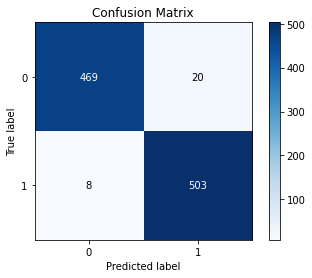

In [12]:
predict_result(model, train_x[:1000], train_y[:1000])

In [13]:
predict_result(model, test_x, test_y)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

# Feature 2 (Spacy document vector)

In [14]:
def get_spacy_vector_and_one_hot(df):
    text_list = df['text'].to_list()
    x = []
    for doc in tqdm_notebook(nlp.pipe(text_list, disable=["tagger", "parser", "lemmatizer", 'attribute_ruler', 'ner']),total=len(text_list) ):
        x.append(doc.vector)
    x = pd.DataFrame(x)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [15]:
train_val_x, train_val_y = get_spacy_vector_and_one_hot(train_df)
test_x, test_y = get_spacy_vector_and_one_hot(test_df)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

# Splitting training data into train and validation set

In [16]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 2 (FFNN w Spacy Doc Vector)

In [17]:
model = Sequential([
    Dense(512, input_shape=(300,), activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_spacy_ffnn/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               154112    
                                                                 
 dense_5 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)             

In [18]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/50
617/625 [============================>.] - ETA: 0s - loss: 0.4075 - accuracy: 0.8194
Epoch 1: val_accuracy improved from -inf to 0.80720, saving model to ./models_spacy_ffnn\checkpoint
625/625 [==============================] - 3s 4ms/step - loss: 0.4068 - accuracy: 0.8199 - val_loss: 0.4012 - val_accuracy: 0.8072
Epoch 2/50
621/625 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8427
Epoch 2: val_accuracy improved from 0.80720 to 0.85160, saving model to ./models_spacy_ffnn\checkpoint
625/625 [==============================] - 2s 4ms/step - loss: 0.3613 - accuracy: 0.8429 - val_loss: 0.3479 - val_accuracy: 0.8516
Epoch 3/50
621/625 [============================>.] - ETA: 0s - loss: 0.3479 - accuracy: 0.8527
Epoch 3: val_accuracy improved from 0.85160 to 0.85720, saving model to ./models_spacy_ffnn\checkpoint
625/625 [==============================] - 2s 4ms/step - loss: 0.3480 - accuracy: 0.8528 - val_loss: 0.3421 - val_accuracy: 0.8572
Epoch 4/50
60

625/625 [==============================] - 2s 3ms/step - loss: 0.0814 - accuracy: 0.9686 - val_loss: 0.8625 - val_accuracy: 0.8420
Epoch 30/50
610/625 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9699
Epoch 30: val_accuracy did not improve from 0.86360
625/625 [==============================] - 2s 3ms/step - loss: 0.0797 - accuracy: 0.9702 - val_loss: 0.9038 - val_accuracy: 0.8434
Epoch 31/50
612/625 [============================>.] - ETA: 0s - loss: 0.0777 - accuracy: 0.9707
Epoch 31: val_accuracy did not improve from 0.86360
625/625 [==============================] - 2s 3ms/step - loss: 0.0779 - accuracy: 0.9707 - val_loss: 1.0803 - val_accuracy: 0.8458
Epoch 32/50
624/625 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9725
Epoch 32: val_accuracy did not improve from 0.86360
625/625 [==============================] - 2s 3ms/step - loss: 0.0744 - accuracy: 0.9725 - val_loss: 0.8516 - val_accuracy: 0.8432
Epoch 33/50
625/625 [========

In [19]:
model.load_weights('./models_spacy_ffnn/checkpoint')

f1 : 0.890625
acc: 0.888


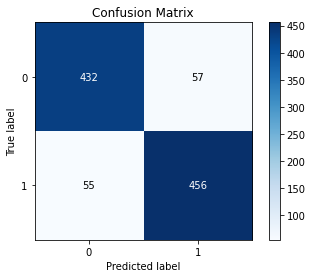

In [20]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.854632972322503
acc: 0.85504


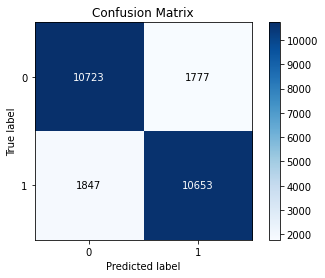

In [21]:
predict_result(model, test_x, test_y)

# Feature 3 (Text to Sequences)

In [22]:
def get_sequences_and_one_hot(df):
    sequences = tokenizer.texts_to_sequences(df['text'].values)
    x = pad_sequences(sequences, maxlen=max_words)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [23]:
train_val_x, train_val_y = get_sequences_and_one_hot(train_df)
test_x, test_y = get_sequences_and_one_hot(test_df)

In [24]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 3 (LSTM)

In [25]:
model = Sequential([
    Embedding(256, embedding_size, input_length=max_words),
    LSTM(128),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_t2s_lstm/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          76800     
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [26]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=256,
         epochs=10,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/10
77/79 [============================>.] - ETA: 0s - loss: 0.5955 - accuracy: 0.6818
Epoch 1: val_accuracy improved from -inf to 0.75880, saving model to ./models_t2s_lstm\checkpoint
79/79 [==============================] - 5s 37ms/step - loss: 0.5937 - accuracy: 0.6835 - val_loss: 0.5143 - val_accuracy: 0.7588
Epoch 2/10
77/79 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.7791
Epoch 2: val_accuracy improved from 0.75880 to 0.78300, saving model to ./models_t2s_lstm\checkpoint
79/79 [==============================] - 3s 34ms/step - loss: 0.4781 - accuracy: 0.7790 - val_loss: 0.4592 - val_accuracy: 0.7830
Epoch 3/10
79/79 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.7858
Epoch 3: val_accuracy did not improve from 0.78300
79/79 [==============================] - 2s 31ms/step - loss: 0.4620 - accuracy: 0.7858 - val_loss: 0.5066 - val_accuracy: 0.7748
Epoch 4/10
79/79 [==============================] - ETA: 0s - loss: 0.4494 - a

In [27]:
model.load_weights('./models_t2s_lstm/checkpoint')

f1 : 0.8156097560975609
acc: 0.811


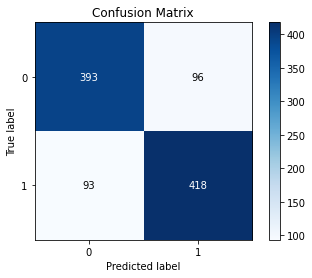

In [28]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.7897383515361044
acc: 0.78592


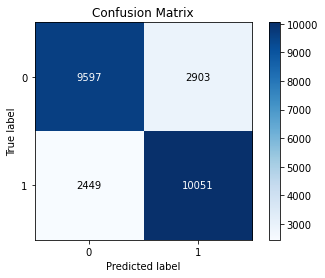

In [29]:
predict_result(model, test_x, test_y)

# Model 3 (GRU)

In [30]:
model = Sequential([
    Embedding(256, embedding_size, input_length=max_words),
    GRU(128),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_t2s_gru/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          76800     
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 2)                 130       
                                                                 
Total params: 250,306
Trainable params: 250,306
Non-tr

In [31]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=128,
         epochs=10,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.6444
Epoch 1: val_accuracy improved from -inf to 0.74580, saving model to ./models_t2s_gru\checkpoint
157/157 [==============================] - 6s 30ms/step - loss: 0.6264 - accuracy: 0.6444 - val_loss: 0.5103 - val_accuracy: 0.7458
Epoch 2/10
156/157 [============================>.] - ETA: 0s - loss: 0.4891 - accuracy: 0.7727
Epoch 2: val_accuracy improved from 0.74580 to 0.77280, saving model to ./models_t2s_gru\checkpoint
157/157 [==============================] - 4s 28ms/step - loss: 0.4891 - accuracy: 0.7727 - val_loss: 0.4768 - val_accuracy: 0.7728
Epoch 3/10
156/157 [============================>.] - ETA: 0s - loss: 0.4655 - accuracy: 0.7884
Epoch 3: val_accuracy improved from 0.77280 to 0.78340, saving model to ./models_t2s_gru\checkpoint
157/157 [==============================] - 4s 27ms/step - loss: 0.4655 - accuracy: 0.7885 - val_loss: 0.4543 - val_accuracy: 0.7834
Epoch 4/10
156/157 

In [32]:
model.load_weights('./models_t2s_gru/checkpoint')

f1 : 0.8354935194416749
acc: 0.835


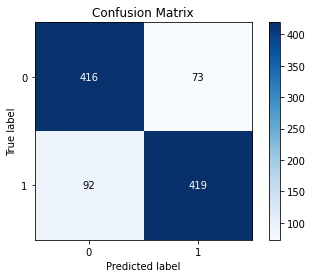

In [33]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.7884201551017094
acc: 0.79156


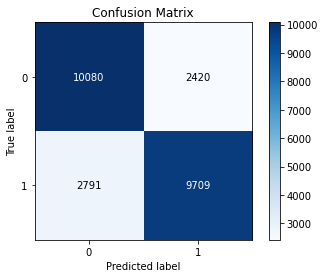

In [34]:
predict_result(model, test_x, test_y)

# Model 4 (Bi-LSTM)

In [35]:
model = Sequential([
    Embedding(256, embedding_size, input_length=max_words),
    Bidirectional(LSTM(256)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_t2s_bilstm/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          76800     
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1140736   
 l)                                                              
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                32832     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 2)                 130       
                                                      

In [36]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=128,
         epochs=10,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/10
156/157 [============================>.] - ETA: 0s - loss: 0.5958 - accuracy: 0.6832
Epoch 1: val_accuracy improved from -inf to 0.66580, saving model to ./models_t2s_bilstm\checkpoint
157/157 [==============================] - 12s 63ms/step - loss: 0.5958 - accuracy: 0.6833 - val_loss: 0.6160 - val_accuracy: 0.6658
Epoch 2/10
156/157 [============================>.] - ETA: 0s - loss: 0.5239 - accuracy: 0.7516
Epoch 2: val_accuracy improved from 0.66580 to 0.76880, saving model to ./models_t2s_bilstm\checkpoint
157/157 [==============================] - 9s 60ms/step - loss: 0.5239 - accuracy: 0.7517 - val_loss: 0.4863 - val_accuracy: 0.7688
Epoch 3/10
156/157 [============================>.] - ETA: 0s - loss: 0.4739 - accuracy: 0.7835
Epoch 3: val_accuracy improved from 0.76880 to 0.77760, saving model to ./models_t2s_bilstm\checkpoint
157/157 [==============================] - 9s 61ms/step - loss: 0.4739 - accuracy: 0.7834 - val_loss: 0.4666 - val_accuracy: 0.7776
Epoch 4/1

In [37]:
model.load_weights('./models_t2s_bilstm/checkpoint')

f1 : 0.821811100292113
acc: 0.817


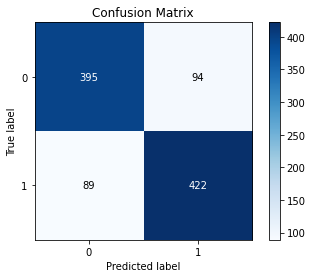

In [38]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.7905548996458087
acc: 0.78712


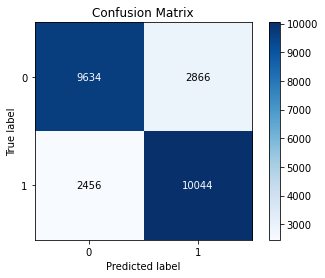

In [39]:
predict_result(model, test_x, test_y)

# Feature 3 (Glove Embeddings)

In [40]:
path = './glove.42B.300d/glove.42B.300d.txt'

embeddings_index = {}

with open(path, encoding='utf8') as f:
    for line in tqdm_notebook(f):
        word, coef = line.split(maxsplit=1)
        coef = np.fromstring(coef, 'f', sep=' ')
        embeddings_index[word] = coef
        
len(embeddings_index)

0it [00:00, ?it/s]

1917494

In [41]:
embedding_dim = 300

num_tokens = len(vocab) + 2

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None :
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18943 words (1057 misses)


In [42]:
def get_vector_and_one_hot(df):
    x = vectorizer(np.array([[s] for s in tqdm_notebook(df['text'])])).numpy() 
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [43]:
train_val_x, train_val_y = get_vector_and_one_hot(train_df)
test_x, test_y = get_vector_and_one_hot(test_df)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [44]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 4 

In [45]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Dense(256, activation="relu")(embedded_sequences)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = GlobalMaxPooling1D()(x)

preds = Dense(2, activation="sigmoid")(x)

model = tf.keras.Model(int_sequences_input, preds)

callbacks=[
    ModelCheckpoint(filepath='./models_glove_ffnn/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 300)         6000600   
                                                                 
 dense_17 (Dense)            (None, None, 256)         77056     
                                                                 
 dropout_12 (Dropout)        (None, None, 256)         0         
                                                                 
 dense_18 (Dense)            (None, None, 256)         65792     
                                                                 
 dropout_13 (Dropout)        (None, None, 256)         0         
                                                                 
 dense_19 (Dense)            (None, None, 256)         65792 

In [46]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=128,
         epochs=100,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/100
156/157 [============================>.] - ETA: 0s - loss: 0.5049 - accuracy: 0.7475
Epoch 1: val_accuracy improved from -inf to 0.80060, saving model to ./models_glove_ffnn\checkpoint
157/157 [==============================] - 3s 17ms/step - loss: 0.5047 - accuracy: 0.7477 - val_loss: 0.4465 - val_accuracy: 0.8006
Epoch 2/100
154/157 [============================>.] - ETA: 0s - loss: 0.3700 - accuracy: 0.8402
Epoch 2: val_accuracy improved from 0.80060 to 0.80560, saving model to ./models_glove_ffnn\checkpoint
157/157 [==============================] - 3s 16ms/step - loss: 0.3695 - accuracy: 0.8406 - val_loss: 0.4546 - val_accuracy: 0.8056
Epoch 3/100
154/157 [============================>.] - ETA: 0s - loss: 0.3553 - accuracy: 0.8474
Epoch 3: val_accuracy improved from 0.80560 to 0.84620, saving model to ./models_glove_ffnn\checkpoint
157/157 [==============================] - 3s 16ms/step - loss: 0.3554 - accuracy: 0.8470 - val_loss: 0.4415 - val_accuracy: 0.8462
Epoch 4

155/157 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9179
Epoch 29: val_accuracy did not improve from 0.85540
157/157 [==============================] - 2s 14ms/step - loss: 0.2049 - accuracy: 0.9176 - val_loss: 0.3959 - val_accuracy: 0.8342
Epoch 30/100
154/157 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9169
Epoch 30: val_accuracy did not improve from 0.85540
157/157 [==============================] - 2s 14ms/step - loss: 0.2064 - accuracy: 0.9166 - val_loss: 0.3773 - val_accuracy: 0.8514
Epoch 31/100
154/157 [============================>.] - ETA: 0s - loss: 0.1969 - accuracy: 0.9187
Epoch 31: val_accuracy did not improve from 0.85540
157/157 [==============================] - 2s 14ms/step - loss: 0.1970 - accuracy: 0.9185 - val_loss: 0.3778 - val_accuracy: 0.8446
Epoch 32/100
156/157 [============================>.] - ETA: 0s - loss: 0.2060 - accuracy: 0.9170
Epoch 32: val_accuracy did not improve from 0.85540
157/157 [========

Epoch 58/100
153/157 [============================>.] - ETA: 0s - loss: 0.1552 - accuracy: 0.9379
Epoch 58: val_accuracy did not improve from 0.86480
157/157 [==============================] - 2s 14ms/step - loss: 0.1549 - accuracy: 0.9383 - val_loss: 0.3544 - val_accuracy: 0.8564
Epoch 59/100
153/157 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9395
Epoch 59: val_accuracy did not improve from 0.86480
157/157 [==============================] - 2s 14ms/step - loss: 0.1502 - accuracy: 0.9398 - val_loss: 0.3596 - val_accuracy: 0.8550
Epoch 60/100
154/157 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9398
Epoch 60: val_accuracy did not improve from 0.86480
157/157 [==============================] - 2s 14ms/step - loss: 0.1499 - accuracy: 0.9398 - val_loss: 0.3675 - val_accuracy: 0.8456
Epoch 61/100
154/157 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9404
Epoch 61: val_accuracy did not improve from 0.86480
157/

154/157 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9539
Epoch 87: val_accuracy did not improve from 0.86480
157/157 [==============================] - 2s 14ms/step - loss: 0.1155 - accuracy: 0.9539 - val_loss: 0.3519 - val_accuracy: 0.8506
Epoch 88/100
155/157 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9519
Epoch 88: val_accuracy did not improve from 0.86480
157/157 [==============================] - 2s 14ms/step - loss: 0.1188 - accuracy: 0.9521 - val_loss: 0.3427 - val_accuracy: 0.8524
Epoch 89/100
154/157 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9500
Epoch 89: val_accuracy did not improve from 0.86480
157/157 [==============================] - 2s 14ms/step - loss: 0.1253 - accuracy: 0.9499 - val_loss: 0.3352 - val_accuracy: 0.8594
Epoch 90/100
155/157 [============================>.] - ETA: 0s - loss: 0.1108 - accuracy: 0.9565
Epoch 90: val_accuracy did not improve from 0.86480
157/157 [========

In [47]:
model.load_weights('./models_glove_ffnn/checkpoint')

f1 : 0.9318854886475815
acc: 0.931


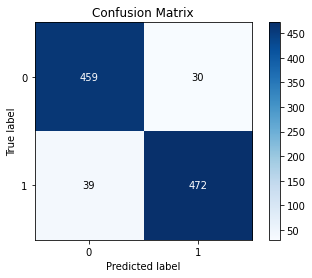

In [48]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8266765897626727
acc: 0.83232


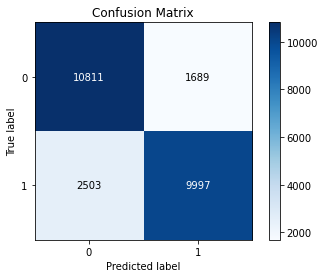

In [49]:
predict_result(model, test_x, test_y)

In [50]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Bidirectional(LSTM(128))(embedded_sequences)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Flatten()(x)

preds = Dense(2, activation="sigmoid")(x)

model = tf.keras.Model(int_sequences_input, preds)

callbacks=[
    ModelCheckpoint(filepath='./models_glove_bilstm/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 300)         6000600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                           

In [ ]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=128,
         epochs=100,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.7582
Epoch 1: val_accuracy improved from -inf to 0.67880, saving model to ./models_glove_bilstm\checkpoint
157/157 [==============================] - 10s 55ms/step - loss: 0.5108 - accuracy: 0.7582 - val_loss: 0.6167 - val_accuracy: 0.6788
Epoch 2/100
157/157 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.8166
Epoch 2: val_accuracy improved from 0.67880 to 0.81920, saving model to ./models_glove_bilstm\checkpoint
157/157 [==============================] - 8s 50ms/step - loss: 0.4285 - accuracy: 0.8166 - val_loss: 0.3963 - val_accuracy: 0.8192
Epoch 3/100
157/157 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8486
Epoch 3: val_accuracy improved from 0.81920 to 0.84700, saving model to ./models_glove_bilstm\checkpoint
157/157 [==============================] - 8s 48ms/step - loss: 0.3668 - accuracy: 0.8486 - val_loss: 0.3535 - val_accuracy: 0.8470


157/157 [==============================] - 7s 47ms/step - loss: 0.0263 - accuracy: 0.9912 - val_loss: 0.6579 - val_accuracy: 0.8786
Epoch 29/100
157/157 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9919
Epoch 29: val_accuracy did not improve from 0.87860
157/157 [==============================] - 7s 46ms/step - loss: 0.0258 - accuracy: 0.9919 - val_loss: 0.7423 - val_accuracy: 0.8648
Epoch 30/100
157/157 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9932
Epoch 30: val_accuracy did not improve from 0.87860
157/157 [==============================] - 7s 48ms/step - loss: 0.0206 - accuracy: 0.9932 - val_loss: 0.7525 - val_accuracy: 0.8738
Epoch 31/100
156/157 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9968
Epoch 31: val_accuracy improved from 0.87860 to 0.87880, saving model to ./models_glove_bilstm\checkpoint
157/157 [==============================] - 8s 51ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss

157/157 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9984
Epoch 57: val_accuracy did not improve from 0.88180
157/157 [==============================] - 7s 45ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.8842 - val_accuracy: 0.8696
Epoch 58/100
157/157 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9979
Epoch 58: val_accuracy did not improve from 0.88180
157/157 [==============================] - 7s 44ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.8721 - val_accuracy: 0.8778
Epoch 59/100
157/157 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9987
Epoch 59: val_accuracy did not improve from 0.88180
157/157 [==============================] - 7s 44ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.9481 - val_accuracy: 0.8780
Epoch 60/100
157/157 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9976
Epoch 60: val_accuracy did not improve from 0.88180
157/157 [========

156/157 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9976
Epoch 86: val_accuracy did not improve from 0.88180
157/157 [==============================] - 7s 46ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 1.0009 - val_accuracy: 0.8776
Epoch 87/100
157/157 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9984
Epoch 87: val_accuracy did not improve from 0.88180
157/157 [==============================] - 7s 46ms/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.9840 - val_accuracy: 0.8732
Epoch 88/100
157/157 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998  
Epoch 88: val_accuracy did not improve from 0.88180
157/157 [==============================] - 7s 45ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 1.0898 - val_accuracy: 0.8730
Epoch 89/100
157/157 [==============================] - ETA: 0s - loss: 9.1455e-04 - accuracy: 0.9998
Epoch 89: val_accuracy did not improve from 0.88180
157/157 [==

In [ ]:
model.load_weights('./models_glove_bilstm/checkpoint')

In [ ]:
predict_result(model, train_x[:1000], train_y[:1000])

In [ ]:
predict_result(model, test_x, test_y)